In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from kmodes.kprototypes import KPrototypes
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from collections import Counter


In [ ]:
# 1. 데이터 불러오기
df = pd.read_csv(
    # "C:/Users/Admin/Desktop/이정수/LG U+/프로젝트3/data/0.perfume_preprocessed.csv", # 정수
    "C:/Users/Admin/Desktop/PROJ/data/02_cleaned/perfume/2.perfume_limited_mainaccord_filtered.csv", # 원선
    # encoding="cp949",
)

### [K-Prototype] Middle + mainaccord 1,2,3 

c:\Users\Admin\anaconda3\envs\mycleanenv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



▶ K = 5 모델 학습 시작
➡ K=5 | K-Prototypes Cost = 618.9132448949094
➡ K=5 | Silhouette (numeric only) = 0.3073611183166212

▶ K = 6 모델 학습 시작
➡ K=6 | K-Prototypes Cost = 572.1571229661772
➡ K=6 | Silhouette (numeric only) = 0.33646174538832535

▶ K = 7 모델 학습 시작
➡ K=7 | K-Prototypes Cost = 541.7393946820849
➡ K=7 | Silhouette (numeric only) = 0.3557892895788036

▶ K = 8 모델 학습 시작
➡ K=8 | K-Prototypes Cost = 515.2421787287375
➡ K=8 | Silhouette (numeric only) = 0.3725321979101161

▶ K = 9 모델 학습 시작
➡ K=9 | K-Prototypes Cost = 501.97771720895054
➡ K=9 | Silhouette (numeric only) = 0.3874369500751366

▶ K = 10 모델 학습 시작
➡ K=10 | K-Prototypes Cost = 477.34276601082234
➡ K=10 | Silhouette (numeric only) = 0.4024685657454305

▶ K = 11 모델 학습 시작
➡ K=11 | K-Prototypes Cost = 458.8488637269111
➡ K=11 | Silhouette (numeric only) = 0.41372014331089135

▶ K = 12 모델 학습 시작
➡ K=12 | K-Prototypes Cost = 431.61907955875535
➡ K=12 | Silhouette (numeric only) = 0.432026312155513

▶ K = 13 모델 학습 시작
➡ K=13 | K-Proto

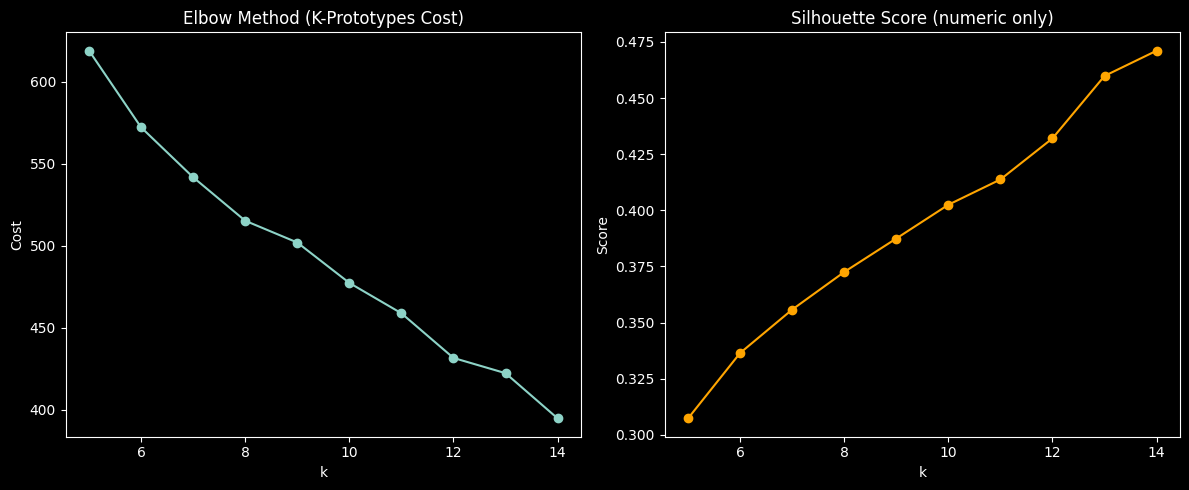

In [83]:
# -----------------------------------------------------------
# 1) Middle 컬럼 → TF-IDF 전처리
# -----------------------------------------------------------
df["Middle_list"] = df["Middle"].apply(lambda x: x.split(","))

Middle_tags = [tag for tags in df["Middle_list"] for tag in tags]
tag_counts = Counter(Middle_tags)

MIN_FREQ = 25
high_freq_tags = {tag for tag, cnt in tag_counts.items() if cnt >= MIN_FREQ}

df["Middle_filtered"] = df["Middle_list"].apply(
    lambda tags: " ".join([t for t in tags if t in high_freq_tags])
)

vectorizer_Middle = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
X_Middle = vectorizer_Middle.fit_transform(df["Middle_filtered"])
X_Middle = normalize(X_Middle)

# -----------------------------------------------------------
# 2) accord_cols는 범주형 그대로 사용
# -----------------------------------------------------------
accord_cols = [
    "mainaccord1",
    # "mainaccord2",
    # "mainaccord3",
]

for c in accord_cols:
    df[c] = df[c].fillna("None").astype(str)

X_acc = df[accord_cols].values

# -----------------------------------------------------------
# 3) 수치형 + 범주형 결합
# -----------------------------------------------------------
X_Middle_dense = X_Middle.toarray()
X_total = np.hstack([X_Middle_dense, X_acc])

num_numeric = X_Middle_dense.shape[1]
categorical_idx = list(range(num_numeric, num_numeric + len(accord_cols)))

# -----------------------------------------------------------
# 4) Elbow + Silhouette + Cost 출력
# -----------------------------------------------------------
K_range = range(5, 15)
costs = []
sil_scores = []

for k in K_range:
    print("\n===============================")
    print(f"▶ K = {k} 모델 학습 시작")
    print("===============================")

    kp = KPrototypes(n_clusters=k, random_state=42, init='Huang')
    labels = kp.fit_predict(X_total, categorical=categorical_idx)

    # Cost 저장 + 출력
    cost_val = kp.cost_
    costs.append(cost_val)
    print(f"➡ K={k} | K-Prototypes Cost = {cost_val}")

    # Silhouette 계산
    sil = silhouette_score(X_Middle_dense, labels)
    sil_scores.append(sil)
    print(f"➡ K={k} | Silhouette (numeric only) = {sil}")

# -----------------------------------------------------------
# K별 cost 요약 출력
# -----------------------------------------------------------
print("\n=======================================")
print("📌 전체 K별 Cost 요약")
print("=======================================")
for k, c in zip(K_range, costs):
    print(f"K={k} → Cost={c}")

# -----------------------------------------------------------
# 5) 시각화
# -----------------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, costs, marker='o')
plt.title("Elbow Method (K-Prototypes Cost)")
plt.xlabel("k")
plt.ylabel("Cost")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o', color='orange')
plt.title("Silhouette Score (numeric only)")
plt.xlabel("k")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


In [74]:
# ===========================================================
# 6) 클러스터 라벨 저장
# ===========================================================
df["cluster"] = labels


# ===========================================================
# 7) Middle(TF-IDF) 기반 주요 노트 추출
# ===========================================================
Middle_feature_names = vectorizer_Middle.get_feature_names_out()

# 클러스터별 TF-IDF 평균
cluster_profiles_middle = (
    pd.DataFrame(X_Middle_dense, columns=Middle_feature_names)
    .assign(cluster=df["cluster"])
    .groupby("cluster")
    .mean()
)

# 클러스터별 상위 10개 노트
top_n = 10
top_middle_notes = {
    c: cluster_profiles_middle.loc[c].sort_values(ascending=False).head(top_n)
    for c in cluster_profiles_middle.index
}


# ===========================================================
# 8) mainaccord 범주형 분포 요약
# ===========================================================
accord_distribution = {}

for c in sorted(df["cluster"].unique()):
    temp = df[df["cluster"] == c][accord_cols]
    accord_distribution[c] = {
        col: temp[col].value_counts(normalize=True).head(10)
        for col in accord_cols
    }


# ===========================================================
# 9) 클러스터별 대표 향수 목록 (5개)
# ===========================================================
sample_perfumes = {}

if "Name" in df.columns:
    for c in sorted(df["cluster"].unique()):
        sample_perfumes[c] = df[df["cluster"] == c].head(5)[
            ["Name", "Middle_filtered"] + accord_cols
        ]


# ===========================================================
# 10) 클러스터 리포트 출력
# ===========================================================
print("\n\n=======================================")
print("📌 Cluster Profiling Report")
print("=======================================\n")

for c in sorted(df["cluster"].unique()):
    print(f"\n\n# --------------------------------------------------")
    print(f"# ⭐ Cluster {c} Summary")
    print(f"# --------------------------------------------------\n")

    # Middle notes
    print("■ Top Middle Notes (TF-IDF 상위 특징 10개)")
    print(top_middle_notes[c])
    print("\n")

    # mainaccord
    print("■ mainaccord 분포 (비율 Top 10)")
    for col in accord_cols:
        print(f"\n- {col}")
        print(accord_distribution[c][col])
    print("\n")

    # 대표 향수
    if c in sample_perfumes:
        print("■ 대표 향수 예시 (상위 5개)")
        print(sample_perfumes[c])
    print("\n--------------------------------------------------")




📌 Cluster Profiling Report



# --------------------------------------------------
# ⭐ Cluster 0 Summary
# --------------------------------------------------

■ Top Middle Notes (TF-IDF 상위 특징 10개)
peony                 0.744865
lily-of-the-valley    0.107454
rose                  0.099804
jasmine               0.093850
magnolia              0.089249
freesia               0.076855
violet                0.067722
sambac                0.036578
neroli                0.032070
mimosa                0.026517
Name: 0, dtype: float64


■ mainaccord 분포 (비율 Top 10)

- mainaccord1
mainaccord1
floral          0.415842
fruity          0.158416
rose            0.148515
citrus          0.069307
fresh           0.059406
white floral    0.039604
amber           0.029703
sweet           0.019802
woody           0.009901
ozonic          0.009901
Name: proportion, dtype: float64

- mainaccord2
mainaccord2
floral          0.297030
fresh           0.148515
fruity          0.118812
rose            0.069307


### [K-Prototype] Middle, Gender : unisex, women

c:\Users\Admin\anaconda3\envs\mycleanenv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



▶ K = 5
Cost = 594.677549999392
Silhouette (note only) = 0.2911422202239612

▶ K = 6
Cost = 543.9954953633705
Silhouette (note only) = 0.32860722711794704

▶ K = 7
Cost = 501.4198071862355
Silhouette (note only) = 0.3549063486688543

▶ K = 8
Cost = 471.288786737438
Silhouette (note only) = 0.3801060585520349

▶ K = 9
Cost = 452.42780280715635
Silhouette (note only) = 0.3874186159987439

▶ K = 10
Cost = 440.16995015797136
Silhouette (note only) = 0.3990015179833362

▶ K = 11
Cost = 417.0998592778782
Silhouette (note only) = 0.42005076266259267

▶ K = 12
Cost = 403.5577278396532
Silhouette (note only) = 0.422036706723401

▶ K = 13
Cost = 383.1278365511237
Silhouette (note only) = 0.4463766524788412

▶ K = 14
Cost = 364.3785708373833
Silhouette (note only) = 0.4623989635560535


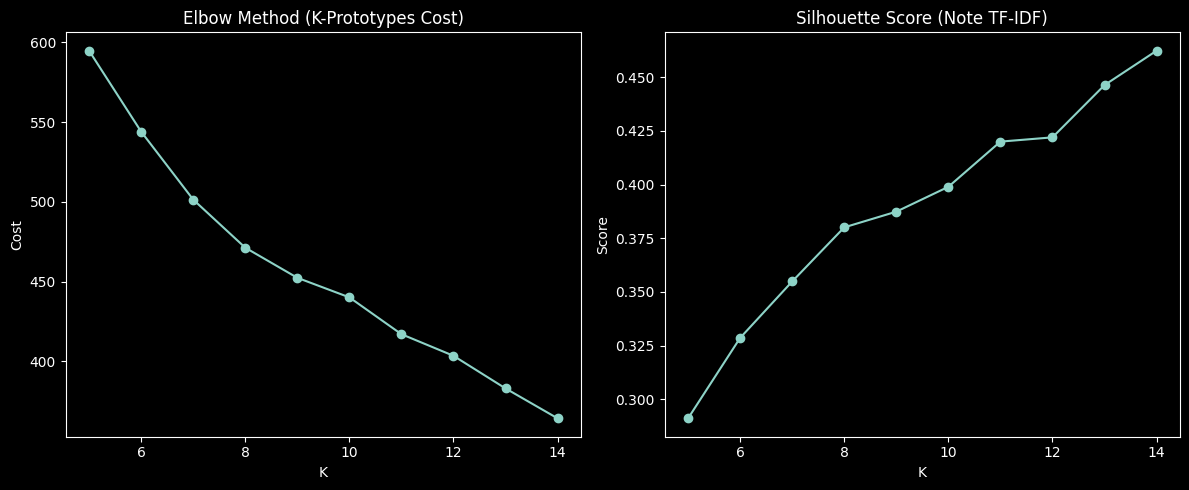

In [84]:
# -----------------------------------------------------------
# 1) Middle 노트 분리
# -----------------------------------------------------------
df["Middle_list"] = df["Middle"].fillna("").apply(lambda x: x.split(","))

# -----------------------------------------------------------
# 2) 노트 빈도 기반 필터링 (권장)
# -----------------------------------------------------------
# 너무 희귀한 노트는 군집 노이즈가 되므로 제거
all_notes = [n for notes in df["Middle_list"] for n in notes]
note_counter = Counter(all_notes)

MIN_FREQ = 25  # 필요 시 조정
high_freq_notes = {n for n, c in note_counter.items() if c >= MIN_FREQ}

# 필터링된 노트만 다시 문자열로 결합 (TF-IDF 입력용)
df["Note_filtered"] = df["Middle_list"].apply(
    lambda notes: " ".join([n for n in notes if n in high_freq_notes])
)
# -----------------------------------------------------------
# 3) TF-IDF 벡터화 (Middle + Base)
# -----------------------------------------------------------
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x.split(),
    lowercase=True
)

X_note = vectorizer.fit_transform(df["Note_filtered"])

# 노트 개수보다 '조합 비율'에 집중하기 위해 정규화
X_note = normalize(X_note)
X_note_dense = X_note.toarray()


# -----------------------------------------------------------
# 4) Gender 범주형 처리
# -----------------------------------------------------------
# Gender는 수치화하지 않고 categorical로 사용
df["Gender"] = df["Gender"].fillna("unknown").astype(str)
X_gender = df[["Gender"]].values


# -----------------------------------------------------------
# 5) 수치형 + 범주형 결합 (K-Prototypes 입력)
# -----------------------------------------------------------
# 앞부분: TF-IDF (numeric)
# 뒷부분: Gender (categorical)
X_total = np.hstack([X_note_dense, X_gender])

num_numeric = X_note_dense.shape[1]
categorical_idx = [num_numeric]  # Gender 컬럼 위치


# -----------------------------------------------------------
# 6) K 탐색 (Elbow + Silhouette)
# -----------------------------------------------------------
K_range = range(5, 15)
costs = []
sil_scores = []

for k in K_range:
    print("\n===============================")
    print(f"▶ K = {k}")
    print("===============================")

    kp = KPrototypes(
        n_clusters=k,
        init="Huang",
        random_state=42
    )

    labels = kp.fit_predict(
        X_total,
        categorical=categorical_idx
    )

    # Elbow (K-Prototypes Cost)
    cost_val = kp.cost_
    costs.append(cost_val)
    print(f"Cost = {cost_val}")

    # Silhouette (노트 벡터 기준, numeric only)
    sil = silhouette_score(X_note_dense, labels)
    sil_scores.append(sil)
    print(f"Silhouette (note only) = {sil}")


# -----------------------------------------------------------
# 7) Elbow / Silhouette 시각화
# -----------------------------------------------------------
plt.figure(figsize=(12, 5))

# Elbow
plt.subplot(1, 2, 1)
plt.plot(K_range, costs, marker="o")
plt.title("Elbow Method (K-Prototypes Cost)")
plt.xlabel("K")
plt.ylabel("Cost")

# Silhouette
plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker="o")
plt.title("Silhouette Score (Note TF-IDF)")
plt.xlabel("K")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


In [85]:
# -----------------------------------------------------------
# 8) 클러스터링
# -----------------------------------------------------------
K = 11

kp = KPrototypes(
    n_clusters=K,
    init="Huang",
    random_state=42
)

df["cluster"] = kp.fit_predict(
    X_total,
    categorical=categorical_idx
)

print("✅ K=11 클러스터링 완료")
print(df["cluster"].value_counts().sort_index())

✅ K=11 클러스터링 완료
cluster
0      69
1     119
2     105
3      34
4     113
5      80
6      39
7      67
8     120
9     364
10    124
Name: count, dtype: int64


In [86]:
# -----------------------------------------------------------
# 9) 클러스터 요약
# -----------------------------------------------------------
TOP_N = 10

feature_names = np.array(vectorizer.get_feature_names_out())

for cluster_id in sorted(df["cluster"].unique()):

    print("=" * 37)
    print(f"### 📌 Cluster {cluster_id} 요약")
    print("=" * 37)
    print()

    cluster_df = df[df["cluster"] == cluster_id]
    idxs = cluster_df.index.tolist()

    # -----------------------------
    # 1) Gender 분포
    # -----------------------------
    print("▶ Gender 분포")
    gender_counts = cluster_df["Gender"].value_counts()
    for gender, cnt in gender_counts.items():
        print(f"- {gender}: {cnt}")
    print()

    # -----------------------------
    # 2) Top Notes (Middle + Base 통합, TF-IDF)
    # -----------------------------
    cluster_tfidf = X_note[idxs].toarray()
    mean_tfidf = cluster_tfidf.mean(axis=0)

    top_idx = np.argsort(mean_tfidf)[::-1][:TOP_N]

    #print("▶ Top Notes (Middle + Base, TF-IDF 기반)")
    print("▶ Top Notes (Middle, TF-IDF 기반)")

    for i in top_idx:
        if mean_tfidf[i] > 0:
            print(f"- {feature_names[i]}: {mean_tfidf[i]:.4f}")
    print()


### 📌 Cluster 0 요약

▶ Gender 분포
- women: 48
- unisex: 21

▶ Top Notes (Middle, TF-IDF 기반)
- violet: 0.7357
- rose: 0.1707
- iris: 0.1030
- jasmine: 0.1029
- peony: 0.0913
- lily-of-the-valley: 0.0593
- mimosa: 0.0504
- freesia: 0.0404
- carnation: 0.0362
- ylang-ylang: 0.0276

### 📌 Cluster 1 요약

▶ Gender 분포
- women: 100
- unisex: 19

▶ Top Notes (Middle, TF-IDF 기반)
- tuberose: 0.3031
- ylang-ylang: 0.2687
- jasmine: 0.2119
- orchid: 0.1555
- carnation: 0.1468
- rose: 0.1017
- neroli: 0.0717
- sambac: 0.0597
- lily: 0.0560
- mimosa: 0.0226

### 📌 Cluster 2 요약

▶ Gender 분포
- women: 84
- unisex: 21

▶ Top Notes (Middle, TF-IDF 기반)
- peony: 0.4982
- freesia: 0.2550
- sambac: 0.1871
- jasmine: 0.1747
- rose: 0.0765
- peach: 0.0309
- neroli: 0.0260
- lily: 0.0217
- mimosa: 0.0151
- lily-of-the-valley: 0.0139

### 📌 Cluster 3 요약

▶ Gender 분포
- women: 17
- unisex: 17

▶ Top Notes (Middle, TF-IDF 기반)
- patchouli: 0.8414
- iris: 0.1738
- rose: 0.1600
- jasmine: 0.1168
- violet: 0.0371
- tuberos